## Import Libraries

In [1]:
import torchvision
from torchvision.transforms import transforms
from torchvision import transforms, datasets, models
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

import matplotlib.pyplot as plt
import PIL  

import logging
import os
import sys
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Configurations (Batch_size = 256)

In [ ]:
# Random self-supervised accuracy is 1/(2*batch_size)
batch_size = 256
lr = 0.01 
weight_decay = 1e-4
n_views = 2
epochs = 20
temperature = 0.07

torch.manual_seed(0)

## Helper Methods

In [ ]:

############## Gaussian Blur Transformation ##############################

class GaussianBlur(object):
    """blur a single image on CPU"""
    def __init__(self, kernel_size):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(3, 3, kernel_size=(kernel_size, 1),
                                stride=1, padding=0, bias=False, groups=3)
        self.blur_v = nn.Conv2d(3, 3, kernel_size=(1, kernel_size),
                                stride=1, padding=0, bias=False, groups=3)
        self.k = kernel_size
        self.r = radias

        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )

        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()

    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)

        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)

        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))

        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()

        img = self.tensor_to_pil(img)

        return img

####################### Display a tensor image grid ############################

def imshow(img):
    img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


    

## Loading & Augmenting Data

Following contains classes which are used to fetch and create augmented image pairs from Cifar10 train dataset 

In [ ]:

###################### Create Augmented Pairs #############################

class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]

################ Transformations & dataset creation #######################

class ContrastiveLearningDataset():

    def __init__(self):
       pass

    @staticmethod
    def get_simclr_pipeline_transform(size, mode='normal', s=1):

        #_______________________Part_1__________Normal_Augmentation_______________________

        if mode == 'normal':
          # Return a set of data augmentation transformations as described in the SimCLR paper.
          color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
          data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomApply([color_jitter], p=0.8),
                                                transforms.RandomGrayscale(p=0.2),
                                                GaussianBlur(kernel_size=int(0.1 * size)),
                                                transforms.ToTensor()])
          
        #______________________Part_2___________Solarization______________________________
        elif mode == 'solarization':
          # Add Solarization ( probability=0.1, threshold=100/255 ) to the transforms
          color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
          data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomApply([color_jitter], p=0.8),
                                                transforms.RandomGrayscale(p=0.2),
                                                GaussianBlur(kernel_size=int(0.1 * size)),
                                                transforms.ToTensor(),
                                                transforms.RandomApply([ # Solarization is Tensor transformation. It requires image values from 0 to 255
                                                  transforms.Lambda(lambda x: transforms.functional.solarize(x*255, 100) / 255), 
                                                  ], p=0.1),
                                                ])
          
        elif mode == 'crop': # Only Randrom Crop
          data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
                                                transforms.ToTensor(),
                                                ])
        return data_transforms
        

    def get_dataset(self, mode='normal'):
        return datasets.CIFAR10('./', train=True,
                                transform=ContrastiveLearningViewGenerator(
                                self.get_simclr_pipeline_transform(32, mode=mode),
                                n_views=2),
                                download=True)


## ResNet18 Model

Load pytorch model resnet18(10 class output) and add MLP projection head behind FC Layer.

Each Image representation is a vector with 512 elements. Output shows the new FC layers.

In [ ]:
class ResNet18_SimCLR(nn.Module):

    def __init__(self):
        super(ResNet18_SimCLR, self).__init__()

        # Resnet18 model
        self.backbone = models.resnet18(pretrained=False, num_classes=10)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def forward(self, x):
        return self.backbone(x)

res = ResNet18_SimCLR()

print('testing... output size: ')
net = res(torch.randn(2, 3, 32, 32))
print(net.size())
res.backbone.fc

## SimCLR Class

This class contains functions for training the model. 

The contrastive loss is defined here

Remove Hardest Loss (part 3) is done inside info_nce_loss function

In [ ]:

class SimCLR(object):

    def __init__(self, **kwargs):
        self.model = kwargs['model'] #.to('cuda')
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.criterion = torch.nn.CrossEntropyLoss() #.to('cuda')
        self.best_acc = 0
        self.start_epoch = 0


    ############################ Contrastive Loss ##################################


    def info_nce_loss(self, features, remove_hardest_loss):

        # Create label indeces for masking
        labels = torch.cat([torch.arange(batch_size) for i in range(n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to('cuda')

        # Measure Cosine similarity matrix of features
        features = F.normalize(features, dim=1)
        similarity_matrix = torch.matmul(features, features.T) 

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to('cuda')
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # positive indeces for each feature are: i and i + batch_size (for i in batch_index)
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # negative indeces for each feature are: i and anything but (i + batch)
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)


        #________________Part_3____Remove Hardest_Loss______________________

        if remove_hardest_loss == True:
          mid_index = negatives.size()[1] // 2

          _, argmax = negatives.max(1) #Get index of max similiar negative
          argmax1 = argmax - (argmax >= mid_index) * mid_index # index for 1st augmented featues in negative pairs
          argmax2 = argmax1 + mid_index # index for 2nd augmented featues in negative pairs
          # Onehot encode argmaxes to create mask
          argmax1 = torch.nn.functional.one_hot(argmax1, num_classes=negatives.size()[1]) 
          argmax2 = torch.nn.functional.one_hot(argmax2, num_classes=negatives.size()[1]) 
          # Remove both versions of most similar negative image from negatives...
          # 2 is subtracted from size of negatives last dimension
          negatives = negatives[~(argmax1.bool() + argmax2.bool())].view(-1, negatives.size()[1] - 2) 

        #___________________________________________________________________

        # Positives are at 0 index in logits
        logits = torch.cat([positives, negatives], dim=1) 

        # label is always 0 so positives should always be bigger than negatives...
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to('cuda')   
        logits = logits / temperature #NT-X loss has temp
        return logits, labels


    ################################# Checkpoint ####################################


    def load_from_checkpoint(self):
        try:
          # Load checkpoint.
          print('==> Resuming from checkpoint..')
          checkpoint = torch.load(checkpoint_dir + 'ckpt.pth')
          self.model.load_state_dict(checkpoint['model'])
          self.optimizer.load_state_dict(checkpoint['optimizer'])
          self.best_acc = checkpoint['acc']
          self.start_epoch = checkpoint['epoch'] + 1
          self.scheduler.load_state_dict(checkpoint['scheduler'])

          print('best accuracy and epoch:')
          print(self.best_acc)
          print(self.start_epoch)

        except:
          a = input('no checkpoint detected... start from beginning? (y/n)')
          if a == 'n':
            exit()


    def save_checkpoint(self, acc, epoch):
            if acc > self.best_acc:
                print('Saving..')
                state = {
                    'model': self.model.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    'scheduler': self.scheduler.state_dict(),
                    'acc': acc,
                    'epoch': epoch
                }
                if not os.path.isdir(checkpoint_dir):
                    os.mkdir(checkpoint_dir)
                torch.save(state, checkpoint_dir + 'ckpt.pth')
                self.best_acc = acc  

  ################################ Training ##############################################


    def train(self, train_loader, resume = 0, remove_hardest_loss = False):

        if resume == 1: # Load from checkpoint
          self.load_from_checkpoint()

        for epoch_counter in range(epochs):
            print('\nEpoch: %d' % (epoch_counter + self.start_epoch))

            # Train
            self.trainstep(train_loader, epoch_counter + self.start_epoch, remove_hardest_loss) 

            # warmup for the first 10 epochs
            if epoch_counter + self.start_epoch >= 10:
                self.scheduler.step() # Lower learning-rate
                print('learning_rate', self.scheduler.get_lr()[0])


    def trainstep(self, train_loader, epoch, remove_hardest_loss):
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (images, _) in enumerate(train_loader):
                
                images = torch.cat(images, dim=0)
                images = images.to('cuda')

                features = self.model(images)

                logits, labels = self.info_nce_loss(features, remove_hardest_loss) # Get loss
                loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            print('[%d, %5d] Loss: %.3f | Acc: %.3f (%d/%d)' % (batch_idx, len(train_loader), train_loss/(batch_idx+1), 100.*correct/total, correct, total))

            # Save checkpoint
            acc = 100.*correct/total
            self.save_checkpoint(acc, epoch)

# Part 1 Training

## Load data

In [ ]:
# Load dataset (Augmentated image pairs are created)
dataset = ContrastiveLearningDataset()
train_dataset = dataset.get_dataset(mode='normal')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
  pin_memory=True, drop_last=True)


Extracting ./cifar-10-python.tar.gz to ./


## Show data

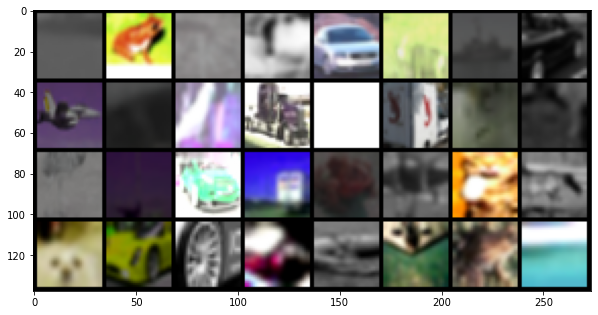

In [ ]:
plt.figure(figsize=(10, 10))

s = iter(train_loader)
x, y = s.next()

x = torch.cat(x, dim=0)
imshow(torchvision.utils.make_grid(x[:32]))

## Train self-supervised model

Model is saved after training for 20 epochs

Loss: 5.348 | Acc: 3.698 % (3692/99840)

Random Accuracy would be 0.0019 %. So we accept it :)

In [ ]:
model = ResNet18_SimCLR()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                        last_epoch=-1)

with torch.cuda.device('cuda'):
  simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler)
  simclr.train(train_loader, resume = 0)


Epoch: 0
[194,   195] Loss: 6.109 | Acc: 0.733 (732/99840)
Saving..

Epoch: 1
[194,   195] Loss: 5.996 | Acc: 0.638 (637/99840)

Epoch: 2
[194,   195] Loss: 5.911 | Acc: 0.884 (883/99840)
Saving..

Epoch: 3
[194,   195] Loss: 5.792 | Acc: 1.239 (1237/99840)
Saving..

Epoch: 4
[194,   195] Loss: 5.716 | Acc: 1.732 (1729/99840)
Saving..

Epoch: 5
[194,   195] Loss: 5.609 | Acc: 2.487 (2483/99840)
Saving..

Epoch: 6
[194,   195] Loss: 5.575 | Acc: 2.624 (2620/99840)
Saving..

Epoch: 7
[194,   195] Loss: 5.525 | Acc: 3.000 (2995/99840)
Saving..

Epoch: 8
[194,   195] Loss: 5.503 | Acc: 2.912 (2907/99840)

Epoch: 9
[194,   195] Loss: 5.478 | Acc: 3.099 (3094/99840)
Saving..

Epoch: 10
[194,   195] Loss: 5.459 | Acc: 3.159 (3154/99840)
Saving..


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


learning_rate 0.009998702291817641

Epoch: 11
[194,   195] Loss: 5.435 | Acc: 3.214 (3209/99840)
Saving..
learning_rate 0.009995458589723352

Epoch: 12
[194,   195] Loss: 5.417 | Acc: 3.301 (3296/99840)
Saving..
learning_rate 0.009990918652804376

Epoch: 13
[194,   195] Loss: 5.404 | Acc: 3.338 (3333/99840)
Saving..
learning_rate 0.009985083659336026

Epoch: 14
[194,   195] Loss: 5.394 | Acc: 3.550 (3544/99840)
Saving..
learning_rate 0.009977955123725573

Epoch: 15
[194,   195] Loss: 5.379 | Acc: 3.543 (3537/99840)
learning_rate 0.009969534896119186

Epoch: 16
[194,   195] Loss: 5.365 | Acc: 3.666 (3660/99840)
Saving..
learning_rate 0.009959825161921702

Epoch: 17
[194,   195] Loss: 5.360 | Acc: 3.607 (3601/99840)
learning_rate 0.00994882844122938

Epoch: 18
[194,   195] Loss: 5.358 | Acc: 3.619 (3613/99840)
learning_rate 0.009936547588175807

Epoch: 19
[194,   195] Loss: 5.348 | Acc: 3.698 (3692/99840)
Saving..
learning_rate 0.009922985790191076


# Evaluation

Logistic Regression is used to for Supervised Evaluation.

MLP Head is discarded from the trained ResNet, all layers but original FC layer are frozen, and training is done for 20 epochs

### Evaluation Functions

In [ ]:
######################## Load dataset ############################


def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.CIFAR10('./data', train=True, download=True,
                                  transform=transforms.ToTensor())

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.CIFAR10('./data', train=False, download=True,
                                  transform=transforms.ToTensor())

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader


##################### Load trained model ##########################


def load_resnet18():
  model = torchvision.models.resnet18(pretrained=False, num_classes=10).to('cuda')

  # Load weights
  checkpoint = torch.load(checkpoint_dir + 'ckpt.pth', map_location='cuda')
  state_dict = checkpoint['model']

  # Logistic Regression Linear Classifier Model
  for k in list(state_dict.keys()):
    if k.startswith('backbone.'):
      if k.startswith('backbone') and not k.startswith('backbone.fc'):
        # remove prefix
        state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]

  # freeze all layers but the last fc
  for name, param in model.named_parameters():
      if name not in ['fc.weight', 'fc.bias']:
          param.requires_grad = False

  parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
  assert len(parameters) == 2  # fc.weight, fc.bias

  return model


  ##################### Train Linear Classifier ######################


def train(model, train_loader, test_loader):

    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0008)
    criterion = torch.nn.CrossEntropyLoss().to('cuda')

    epochs = 20
    for epoch in range(epochs):
        train_accuracy = 0
        correct = 0
        total = 0
        for counter, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = x_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            logits = model(x_batch)
            loss = criterion(logits, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = logits.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

        train_accuracy = 100.*correct/total

        test_accuracy = 0
        correct = 0
        total = 0
        for counter, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to('cuda')
            y_batch = y_batch.to('cuda')

            logits = model(x_batch)
          
            _, predicted = logits.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

        test_accuracy = 100.*correct/total

        print(f"Epoch {epoch}\t Train accuracy {train_accuracy}\t Test accuracy: {test_accuracy}")

# Part 1 Evaluation

Training is done for 20 epochs

Epoch 13	 Train accuracy 35.736	 Test accuracy: 33.46

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_2/checkpoint/'

# Load data
train_loader, test_loader = get_cifar10_data_loaders(download=True)
# Load pretrained model
model = load_resnet18() 
# Train Supervised Linear Classifier
train(model, train_loader, test_loader) 

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0	 Train accuracy 21.394	 Test accuracy: 26.85
Epoch 1	 Train accuracy 28.938	 Test accuracy: 30.19
Epoch 2	 Train accuracy 31.448	 Test accuracy: 31.7
Epoch 3	 Train accuracy 32.764	 Test accuracy: 32.31
Epoch 4	 Train accuracy 33.576	 Test accuracy: 32.52
Epoch 5	 Train accuracy 34.04	 Test accuracy: 32.67
Epoch 6	 Train accuracy 34.438	 Test accuracy: 32.79
Epoch 7	 Train accuracy 34.786	 Test accuracy: 33.15
Epoch 8	 Train accuracy 35.13	 Test accuracy: 33.16
Epoch 9	 Train accuracy 35.324	 Test accuracy: 33.25
Epoch 10	 Train accuracy 35.466	 Test accuracy: 33.28
Epoch 11	 Train accuracy 35.604	 Test accuracy: 33.35
Epoch 12	 Train accuracy 35.678	 Test accuracy: 33.43
Epoch 13	 Train accuracy 35.736	 Test accuracy: 33.46
Epoch 14	 Train accuracy 35.822	 Test accuracy: 33.36
Epoch 15	 Train accuracy 35.906	 Test accuracy: 33.25
Epoch 16	 Train accuracy 35.986	 Test accuracy: 33.3
Epoch 17	 Train accuracy 36.036	 Test accuracy: 33.3
Epoch 18	 Train accuracy 36.126	 Test accur

# Part 2: Add Solarization Augmentation

## Load data

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_2/checkpoint_solarize/'

dataset = ContrastiveLearningDataset()
train_dataset = dataset.get_dataset(mode = 'solarization') # Solarization Augmentation

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
  pin_memory=True, drop_last=True)


Extracting ./cifar-10-python.tar.gz to ./


## Show Data

Solarization is added to transformations. pixels larger than 100/255 are solarized in 0.1 of images

They appear with weird colors below

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


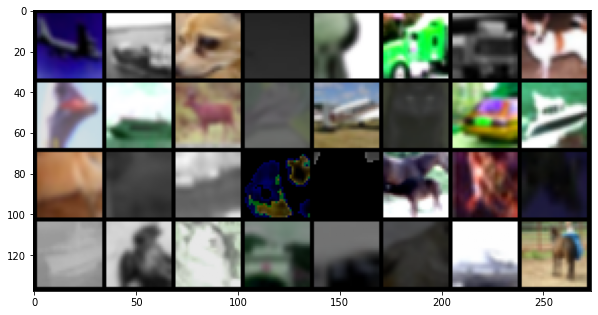

In [ ]:
plt.figure(figsize=(10, 10))
s = iter(train_loader)
x, y = s.next()

x = torch.cat(x, dim=0)
imshow(torchvision.utils.make_grid(x[:32]))

## Train Self-Supervised Model

Model is saved after training for 20 epochs

Loss: 5.272 | Acc: 5.094 (5086/99840

Higher Accuracy...! Let's see how supervised mode is

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_2/checkpoint_solarize/'

model = ResNet18_SimCLR()
model.to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                        last_epoch=-1)
with torch.cuda.device('cuda'):
  simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler)
  simclr.train(train_loader, resume = 1)

==> Resuming from checkpoint..
best accuracy and epoch:
4.887820512820513
17

Epoch: 17
[194,   195] Loss: 5.290 | Acc: 4.998 (4990/99840)
Saving..


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


learning_rate 0.009959825161921702

Epoch: 18
[194,   195] Loss: 5.281 | Acc: 4.962 (4954/99840)
learning_rate 0.00994882844122938

Epoch: 19
[194,   195] Loss: 5.272 | Acc: 5.094 (5086/99840)
Saving..
learning_rate 0.009936547588175807

Epoch: 20


KeyboardInterrupt: ignored

## Evaluation

Training is done for 20 epochs

Epoch 19	 Train accuracy 35.35	 Test accuracy: 33.59

A litttttttle better! 

In [ ]:
train_loader, test_loader = get_cifar10_data_loaders(download=True)
model = load_resnet18()
train(model, train_loader, test_loader)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0	 Train accuracy 20.786	 Test accuracy: 25.42
Epoch 1	 Train accuracy 27.564	 Test accuracy: 29.13
Epoch 2	 Train accuracy 30.252	 Test accuracy: 31.03
Epoch 3	 Train accuracy 31.66	 Test accuracy: 31.84
Epoch 4	 Train accuracy 32.652	 Test accuracy: 32.15
Epoch 5	 Train accuracy 33.212	 Test accuracy: 32.54
Epoch 6	 Train accuracy 33.64	 Test accuracy: 32.79
Epoch 7	 Train accuracy 33.982	 Test accuracy: 33.03
Epoch 8	 Train accuracy 34.226	 Test accuracy: 33.11
Epoch 9	 Train accuracy 34.492	 Test accuracy: 33.31
Epoch 10	 Train accuracy 34.668	 Test accuracy: 33.28
Epoch 11	 Train accuracy 34.788	 Test accuracy: 33.33
Epoch 12	 Train accuracy 34.92	 Test accuracy: 33.28
Epoch 13	 Train accuracy 35.012	 Test accuracy: 33.4
Epoch 14	 Train accuracy 35.104	 Test accuracy: 33.37
Epoch 15	 Train accuracy 35.19	 Test accuracy: 33.41
Epoch 16	 Train accuracy 35.246	 Test accuracy: 33.51
Epoch 17	 Train accuracy 35.27	 Test accuracy: 33.6
Epoch 18	 Train accuracy 35.298	 Test accurac

# Part 2: Keep Only Random Crop Augmentation

## Load data

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_2/checkpoint_solarize/'

dataset = ContrastiveLearningDataset()
train_dataset = dataset.get_dataset(mode = 'crop') # Random Crop Augmentation

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
  pin_memory=True, drop_last=True)


Extracting ./cifar-10-python.tar.gz to ./


## Show Data

Images are only Random Cropped and resized back to original image size

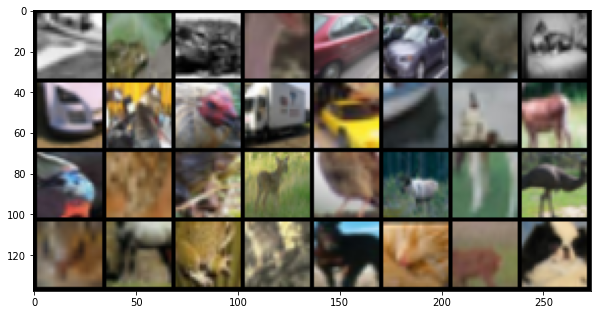

In [ ]:
plt.figure(figsize=(10, 10))
s = iter(train_loader)
x, y = s.next()

x = torch.cat(x, dim=0)
imshow(torchvision.utils.make_grid(x[:32]))

## Train Self-Supervised Model

Model is saved after training for 20 epochs

Loss: 1.527 | Acc: 72.069 (71954/99840)

Recognizing this augmentation is much simpler for the model!


In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_2/checkpoint_crop/'

model = ResNet18_SimCLR()
model = model.to('cuda')

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                        last_epoch=-1)
with torch.cuda.device('cuda'):
  simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler)
  simclr.train(train_loader, resume = 0)


Epoch: 0
[194,   195] Loss: 5.410 | Acc: 4.644 (4637/99840)
Saving..

Epoch: 1
[194,   195] Loss: 4.385 | Acc: 14.815 (14791/99840)
Saving..

Epoch: 2
[194,   195] Loss: 4.236 | Acc: 17.281 (17253/99840)
Saving..

Epoch: 3
[194,   195] Loss: 3.672 | Acc: 30.291 (30243/99840)
Saving..

Epoch: 4
[194,   195] Loss: 3.530 | Acc: 33.044 (32991/99840)
Saving..

Epoch: 5
[194,   195] Loss: 3.329 | Acc: 37.605 (37545/99840)
Saving..

Epoch: 6
[194,   195] Loss: 2.937 | Acc: 46.987 (46912/99840)
Saving..

Epoch: 7
[194,   195] Loss: 2.779 | Acc: 49.242 (49163/99840)
Saving..

Epoch: 8
[194,   195] Loss: 2.455 | Acc: 56.375 (56285/99840)
Saving..

Epoch: 9
[194,   195] Loss: 2.335 | Acc: 58.054 (57961/99840)
Saving..

Epoch: 10
[194,   195] Loss: 2.247 | Acc: 58.748 (58654/99840)
Saving..


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


learning_rate 0.009998702291817641

Epoch: 11
[194,   195] Loss: 2.060 | Acc: 62.239 (62139/99840)
Saving..
learning_rate 0.009995458589723352

Epoch: 12
[194,   195] Loss: 1.877 | Acc: 65.760 (65655/99840)
Saving..
learning_rate 0.009990918652804376

Epoch: 13
[194,   195] Loss: 1.845 | Acc: 66.244 (66138/99840)
Saving..
learning_rate 0.009985083659336026

Epoch: 14
[194,   195] Loss: 1.803 | Acc: 66.727 (66620/99840)
Saving..
learning_rate 0.009977955123725573

Epoch: 15
[194,   195] Loss: 1.741 | Acc: 67.848 (67739/99840)
Saving..
learning_rate 0.009969534896119186

Epoch: 16
[194,   195] Loss: 1.642 | Acc: 70.223 (70111/99840)
Saving..
learning_rate 0.009959825161921702

Epoch: 17
[194,   195] Loss: 1.566 | Acc: 71.728 (71613/99840)
Saving..
learning_rate 0.00994882844122938

Epoch: 18
[194,   195] Loss: 1.538 | Acc: 72.371 (72255/99840)
Saving..
learning_rate 0.009936547588175807

Epoch: 19
[194,   195] Loss: 1.527 | Acc: 72.069 (71954/99840)
learning_rate 0.009922985790191076


## Evaluation

Training is done for 20 epochs

Epoch 17	 Train accuracy 35.462	 Test accuracy: 34.33

A litttttttle better! 

In [ ]:
train_loader, test_loader = get_cifar10_data_loaders(download=True)
model = load_resnet18()
train(model, train_loader, test_loader)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0	 Train accuracy 20.084	 Test accuracy: 26.53
Epoch 1	 Train accuracy 28.084	 Test accuracy: 30.4
Epoch 2	 Train accuracy 30.816	 Test accuracy: 31.85
Epoch 3	 Train accuracy 32.06	 Test accuracy: 32.42
Epoch 4	 Train accuracy 32.906	 Test accuracy: 32.97
Epoch 5	 Train accuracy 33.406	 Test accuracy: 33.25
Epoch 6	 Train accuracy 33.84	 Test accuracy: 33.5
Epoch 7	 Train accuracy 34.162	 Test accuracy: 33.69
Epoch 8	 Train accuracy 34.298	 Test accuracy: 33.73
Epoch 9	 Train accuracy 34.484	 Test accuracy: 33.96
Epoch 10	 Train accuracy 34.764	 Test accuracy: 34.08
Epoch 11	 Train accuracy 34.938	 Test accuracy: 34.17
Epoch 12	 Train accuracy 35.106	 Test accuracy: 34.22
Epoch 13	 Train accuracy 35.186	 Test accuracy: 34.14
Epoch 14	 Train accuracy 35.264	 Test accuracy: 34.16
Epoch 15	 Train accuracy 35.344	 Test accuracy: 34.13
Epoch 16	 Train accuracy 35.39	 Test accuracy: 34.33
Epoch 17	 Train accuracy 35.462	 Test accuracy: 34.33
Epoch 18	 Train accuracy 35.526	 Test accur

# Part 3: Remove Hardest Loss

## Load data

In [ ]:
dataset = ContrastiveLearningDataset()
train_dataset = dataset.get_dataset(mode = 'normal')

batch_size = 256
checkpoint_dir = '/content/drive/MyDrive/ADL/3_2/checkpoint_hardestloss/'

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
  pin_memory=True, drop_last=True)


Files already downloaded and verified


## Train Self-Supervised Model

model is saved after training for 20 epochs

Loss: 5.080 | Acc: 10.784 (10767/99840)

Higher Accuracy from Part 1...! Indeed, removing hardest loss improves loss and accuracy of training because model deals with an easier task

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ADL/3_2/checkpoint_hardestloss/'

model = ResNet18_SimCLR()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                        last_epoch=-1)
with torch.cuda.device('cuda'):
  simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler)
  simclr.train(train_loader, resume = 0, remove_hardest_loss = True) # Remove hardest loss


Epoch: 0
[194,   195] Loss: 6.175 | Acc: 1.390 (1388/99840)
Saving..

Epoch: 1
[194,   195] Loss: 6.003 | Acc: 1.058 (1056/99840)

Epoch: 2
[194,   195] Loss: 5.895 | Acc: 1.894 (1891/99840)
Saving..

Epoch: 3
[194,   195] Loss: 5.761 | Acc: 2.963 (2958/99840)
Saving..

Epoch: 4
[194,   195] Loss: 5.633 | Acc: 4.356 (4349/99840)
Saving..

Epoch: 5
[194,   195] Loss: 5.606 | Acc: 4.676 (4669/99840)
Saving..

Epoch: 6
[194,   195] Loss: 5.551 | Acc: 5.037 (5029/99840)
Saving..

Epoch: 7
[194,   195] Loss: 5.510 | Acc: 5.381 (5372/99840)
Saving..

Epoch: 8
[194,   195] Loss: 5.451 | Acc: 6.460 (6450/99840)
Saving..

Epoch: 9
[194,   195] Loss: 5.314 | Acc: 8.204 (8191/99840)
Saving..

Epoch: 10
[194,   195] Loss: 5.266 | Acc: 8.704 (8690/99840)
Saving..


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:509: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


learning_rate 0.009998702291817641

Epoch: 11
[194,   195] Loss: 5.245 | Acc: 8.878 (8864/99840)
Saving..
learning_rate 0.009995458589723352

Epoch: 12
[194,   195] Loss: 5.188 | Acc: 9.488 (9473/99840)
Saving..
learning_rate 0.009990918652804376

Epoch: 13
[194,   195] Loss: 5.163 | Acc: 9.809 (9793/99840)
Saving..
learning_rate 0.009985083659336026

Epoch: 14
[194,   195] Loss: 5.153 | Acc: 9.906 (9890/99840)
Saving..
learning_rate 0.009977955123725573

Epoch: 15
[194,   195] Loss: 5.143 | Acc: 9.968 (9952/99840)
Saving..
learning_rate 0.009969534896119186

Epoch: 16
[194,   195] Loss: 5.124 | Acc: 9.995 (9979/99840)
Saving..
learning_rate 0.009959825161921702

Epoch: 17
[194,   195] Loss: 5.102 | Acc: 10.482 (10465/99840)
Saving..
learning_rate 0.00994882844122938

Epoch: 18
[194,   195] Loss: 5.110 | Acc: 10.082 (10066/99840)
learning_rate 0.009936547588175807

Epoch: 19
[194,   195] Loss: 5.080 | Acc: 10.784 (10767/99840)
Saving..
learning_rate 0.009922985790191076


## Evaluation

Training is done for 20 epochs

Epoch 10	 Train accuracy 35.0	 Test accuracy: 33.54

A litttttttle better again!

In [ ]:
train_loader, test_loader = get_cifar10_data_loaders(download=True)
model = load_resnet18()
train(model, train_loader, test_loader)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 0	 Train accuracy 20.35	 Test accuracy: 26.25
Epoch 1	 Train accuracy 28.326	 Test accuracy: 29.91
Epoch 2	 Train accuracy 30.908	 Test accuracy: 31.5
Epoch 3	 Train accuracy 32.312	 Test accuracy: 32.37
Epoch 4	 Train accuracy 33.042	 Test accuracy: 32.76
Epoch 5	 Train accuracy 33.582	 Test accuracy: 33.26
Epoch 6	 Train accuracy 33.972	 Test accuracy: 33.49
Epoch 7	 Train accuracy 34.354	 Test accuracy: 33.52
Epoch 8	 Train accuracy 34.686	 Test accuracy: 33.46
Epoch 9	 Train accuracy 34.9	 Test accuracy: 33.53
Epoch 10	 Train accuracy 35.0	 Test accuracy: 33.54
Epoch 11	 Train accuracy 35.146	 Test accuracy: 33.48
Epoch 12	 Train accuracy 35.23	 Test accuracy: 33.45
Epoch 14	 Train accuracy 35.384	 Test accuracy: 33.53
Epoch 15	 Train accuracy 35.436	 Test accuracy: 33.5
Epoch 16	 Train accuracy 35.486	 Test accuracy: 33.45
Epoch 17	 Train accuracy 35.558	 Test accuracy: 33.45
Epoch 18	 Train accuracy 35.614	 Test accuracy: 33.41
Epoch 19	 Train accuracy 35.65	 Test accuracy: